# TBD - Kaggle

## Authors
| **Name**              | **NIU**   |
|-----------------------|-----------|
| Arnau Muñoz Barrera   | 1665982   |
| José Ortín López      | 1667573   |


## Database

To access the source Database: [Link to Database](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)



## Import Libraries

In [38]:
# install required packages in the notebook environment
%pip install pandas numpy seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Review Initial Structure and Data

In [39]:
df = pd.read_csv('data/vehicles-dataset.csv', engine='python', on_bad_lines='skip')

df.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
count,2930,2527,2418,2418,2418,2413,2258,2342,1924,1777,...,1160,1523,1618,2384,2384,0.0,2389,2381.000000,2381.000000,2389
unique,2400,2393,30,30,497,79,38,1014,7,8,...,4,13,12,2081,2144,NaN,4,NaN,NaN,2378
top,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;,rates as low as 2.99%. ;;;;;;;;;;;;;;;;;;;;;...,new york city,https://newyork.craigslist.org,3500,2008,chevrolet,camry,excellent,6 cylinders,...,full-size,sedan,black,https://images.craigslist.org/00505_he8AibINmZ...,BUY HERE PAY HERE ...,NaN,ny,NaN,NaN,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
freq,220,83,445,445,63,180,358,35,843,646,...,641,425,318,7,7,NaN,1883,NaN,NaN,5
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.966901,-75.951059,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.127954,4.900114,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.162608,-121.741100,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.778100,-77.651539,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.605600,-74.011459,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.032056,-73.524000,NaN


##### Determine columns & their types

In [40]:
print("[INFO] Dataset columns & their types: \n", df.dtypes)

[INFO] Dataset columns & their types: 
 id                                                      object
url                                                     object
region                                                  object
region_url                                              object
price                                                   object
year                                                    object
manufacturer                                            object
model                                                   object
condition                                               object
cylinders                                               object
fuel                                                    object
odometer                                                object
title_status                                            object
transmission                                            object
VIN                                                     object
drive          

##### Determine quantity of NaNs

[INFO] Does the dataset have missing values? Yes

 [INFO] Percentage of missing values per column: 
 id                                                     0.000000
url                                                    0.001375
region                                                 0.001747
region_url                                             0.001747
price                                                  0.001747
year                                                   0.001765
fuel                                                   0.001765
odometer                                               0.001765
transmission                                           0.001765
title_status                                           0.001765
posting_date;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;    0.001846
state                                                  0.001846
image_url                                              0.001863
description                                            0.001863
lat

C:\Users\arnau\AppData\Local\Temp\ipykernel_26120\2992473982.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage", y="Field", data=df_missing, palette="viridis")


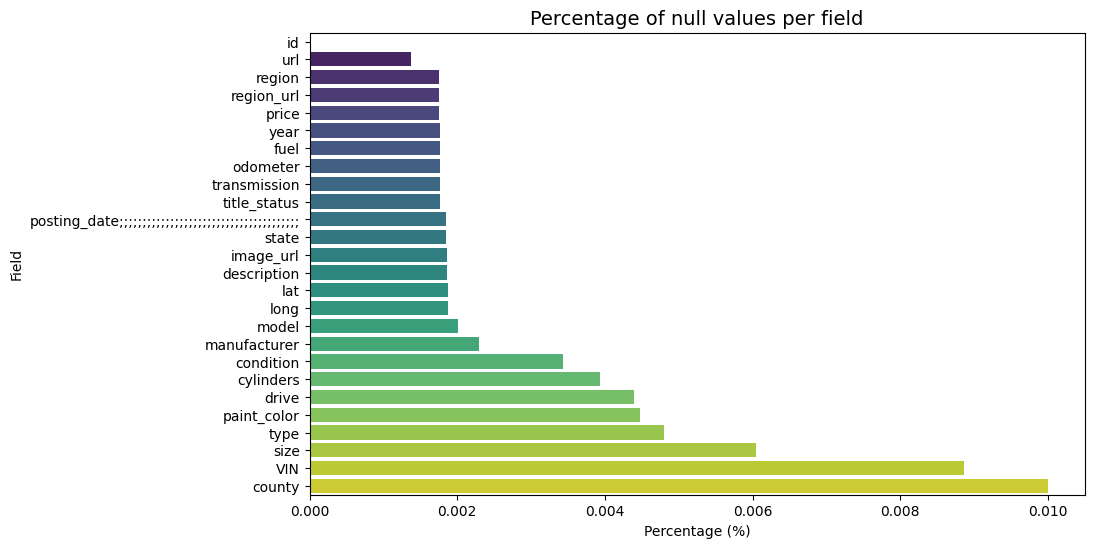

In [41]:
# Auxiliar function to display missing values
def has_nans(df):
    return df.isna().sum().sum() > 0

# Auxiliar function to display percentage of missing values per column
def get_percentage_nan_per_column(df):
    return ((df.isna().sum().sort_values()) / (len(df) * 100))

print("[INFO] Does the dataset have missing values?", "Yes" if has_nans(df) else "No")

if has_nans(df):
    print("\n [INFO] Percentage of missing values per column: \n", get_percentage_nan_per_column(df))

    df_missing = pd.DataFrame(list(get_percentage_nan_per_column(df).items()), columns=["Field", "Percentage"])

    plt.figure(figsize=(10,6))
    sns.barplot(x="Percentage", y="Field", data=df_missing, palette="viridis")

    plt.title("Percentage of null values per field", fontsize=14)
    plt.xlabel("Percentage (%)")
    plt.ylabel("Field")

    plt.show()
else:
    print("\n [INFO] No missing values detected in the dataset.")


### Conclusions

As we can see in previous results, the main initial factors that should be revised & look into are:

| **Problem description**                                | **Proposed Solution**      | **Affected fields**      |
|--------------------------------------------------------|----------------------------|--------------------------|
| Field that needs format clean-up                       | Field modifications        | **posting_date**         |
| Field with most NaN values                             | Erase column               | **county**, **VIN**      |
| Fields with different types or inconsistent ranges     | Normalization              | **price**, **odometer**  |
| Irrelevant fields                                      | Erase column               | **TBD**                  |



### Erase ***County*** & ***VIN***

In [42]:
df = df.drop(['county', 'VIN'], axis=1)
df.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
count,2930,2527,2418,2418,2418,2413,2258,2342,1924,1777,...,1644,1160,1523,1618,2384,2384,2389,2381.000000,2381.000000,2389
unique,2400,2393,30,30,497,79,38,1014,7,8,...,3,4,13,12,2081,2144,4,NaN,NaN,2378
top,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;,rates as low as 2.99%. ;;;;;;;;;;;;;;;;;;;;;...,new york city,https://newyork.craigslist.org,3500,2008,chevrolet,camry,excellent,6 cylinders,...,4wd,full-size,sedan,black,https://images.craigslist.org/00505_he8AibINmZ...,BUY HERE PAY HERE ...,ny,NaN,NaN,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
freq,220,83,445,445,63,180,358,35,843,646,...,804,641,425,318,7,7,1883,NaN,NaN,5
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.966901,-75.951059,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.127954,4.900114,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.162608,-121.741100,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.778100,-77.651539,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.605600,-74.011459,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.032056,-73.524000,NaN
